In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
import glob
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.solver import build_lr_scheduler
from vis import *
from dataset_bjtu import *

import torch
from detectron2.engine import DefaultTrainer

print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())
os.environ["CUDA_VISIBLE_DEVICES"] = "1,"

register_coco_instances("bjtu_train_washed", {}, "BJTU_washed/train.json", ".")
register_coco_instances("bjtu_test_washed", {}, "BJTU_washed/test.json", ".")

True
(9, 0)


In [53]:
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper  # the default mapper
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from fvcore.transforms.transform import (
    CropTransform,
    HFlipTransform,
    NoOpTransform,
    Transform,
    TransformList,
)
import PIL.Image as Image


from detectron2.data import transforms as T


class NoiseAugmentation(T.Augmentation):
    def __init__(self, intensity):
        super().__init__()
        self._init(locals())
    def get_transform(self, image):
        return NoiseTransform(self.intensity)

class NoiseTransform(Transform):

    def __init__(self, intensity):
        # TODO decide on PIL vs opencv
        super().__init__()
        self._set_attributes(locals())

    def apply_image(self, img, interp=None):
        assert len(img.shape) <= 4
        intensity = np.random.uniform(0, self.intensity)
        if img.dtype == np.uint8:
            img = img.astype(np.float32)
            if len(img.shape) > 2 and img.shape[2] == 1:
                noise_mask = np.random.normal(0, intensity, img.shape[:2])
                noise_mask = np.expand_dims(noise_mask, axis=-1)
            else:
                noise_mask = np.random.normal(0, intensity, img.shape)
            ret = img + noise_mask
            ret = np.clip(ret, 0, 255).astype(np.uint8)
        else:
            if any(x < 0 for x in img.strides):
                img = np.ascontiguousarray(img)
            img = torch.from_numpy(img)
            noise = torch.randn_like(img) * intensity
            img = img + noise
            ret = img.numpy()

        return ret

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        return segmentation

class MaskAugmentation(T.Augmentation):
    def __init__(self, k, p, mode="Black"):
        ''' 
        k: grid number
        p: ratio of mask
        mode: "Gaussian" or "Black"
        '''
        super().__init__()
        self._init(locals())
    def get_transform(self, image):
        return MaskTransform(self.k, self.p, self.mode)

class MaskTransform(Transform):
    def __init__(self, k, p ,mode):
        '''
        mode: "Gaussian" or "Black"
        '''
        # TODO decide on PIL vs opencv
        super().__init__()
        self._set_attributes(locals())


    def apply_image(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        img = img.copy()  # Make a copy to ensure no negative strides
        img = torch.tensor(img, dtype=torch.float32)
        h, w = img.shape[:2]
        k, p = self.k, self.p
        mode = self.mode
        num_grid_x = w // k
        num_grid_y = h // k

        num_masked_grids = int(p * num_grid_x * num_grid_y)
        masked_grids = random.sample(range(num_grid_x * num_grid_y), num_masked_grids)

        # Create a grid index array
        grid_indices = torch.arange(num_grid_x * num_grid_y).reshape(num_grid_y, num_grid_x)

        # Set mask for selected grids
        mask_indices = torch.isin(grid_indices, torch.tensor(masked_grids, dtype=torch.int64))
        mask_indices = mask_indices.repeat_interleave(k, dim=0).repeat_interleave(k, dim=1)

        # Adjust the mask size if it is smaller than the image size
        mask = torch.zeros((h, w), dtype=torch.float32)
        mask[:mask_indices.shape[0], :mask_indices.shape[1]] = mask_indices.float()

        # Broadcast mask to match the image channels
        mask = mask.unsqueeze(-1).expand(-1, -1, img.shape[-1])

        if mode == "Gaussian":
            noise = torch.randn_like(img) * mask
            masked_image = img * (1 - mask) + noise
        elif mode == "Black":
            masked_image = img * (1 - mask)
        
        return masked_image.numpy().astype(np.uint8)

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        return segmentation
    

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        return segmentation
    
def build_text_detect_train_aug(cfg):
    
    augs = [
        # T.RandomRotation(angle=[-60, 60], expand=False),
        # T.ResizeScale(0.5,2,1024,1024),
        NoiseAugmentation(60),
        MaskAugmentation(30, 0.2),
        T.RandomCrop("relative_range", [0.5, 0.5]),
        # T.ResizeShortestEdge(
        #     cfg.INPUT.MIN_SIZE_TRAIN,
        #     cfg.INPUT.MAX_SIZE_TRAIN,
        #     cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING,
        # ),
        # T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomLighting(0.7),
        T.RandomResize([[512, 512], [768, 512], [512, 768], [256, 512], [512, 256]])    
    ]
    return augs



class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        os.makedirs(cfg.EVAL_DIR, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, cfg.EVAL_DIR)
    
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)

    @classmethod
    def build_train_loader(cls, cfg):

        mapper = DatasetMapper(
                cfg, is_train=True, augmentations=build_text_detect_train_aug(cfg)
            )

        return build_detection_train_loader(cfg, mapper=mapper)
    
    # @classmethod
    # def build_test_loader(cls, cfg, dataset_name):
    #     return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, is_train=False, augmentations=build_text_detect_val_aug(cfg)))

    # @classmethod
    # def build_lr_scheduler(cls, cfg, optimizer):
    #     """
    #     It now calls :func:`detectron2.solver.build_lr_scheduler`.
    #     Overwrite it if you'd like a different scheduler.
    #     """
    #     return build_lr_scheduler(cfg, optimizer)

cfg = get_cfg()
cfg.merge_from_file("config/final.yaml")
trainer = CocoTrainer(cfg)

[06/19 17:39:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# 修改cfg

[06/19 17:39:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [NoiseAugmentation(intensity=60), MaskAugmentation(k=30, p=0.2), RandomCrop(crop_type='relative_range', crop_size=[0.5, 0.5]), RandomBrightness(intensity_min=0.8, intensity_max=1.8), RandomContrast(intensity_min=0.6, intensity_max=1.3), RandomSaturation(intensity_min=0.8, intensity_max=1.4), RandomLighting(scale=0.7), RandomResize(shape_list=[[512, 512], [768, 512], [512, 768], [256, 512], [512, 256]])]
WARNING [06/19 17:39:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/19 17:39:12 d2.data.datasets.coco]: Loaded 562 images in COCO format from BJTU_washed/train.json
[06/19 17:39:12 d2.data.build]: Removed 0 images with no usable annotations. 562 images left.
[06/19 17:39:12 d2.data.build]: Using training sampler TrainingSampler
[06/19 17:39:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._Torc

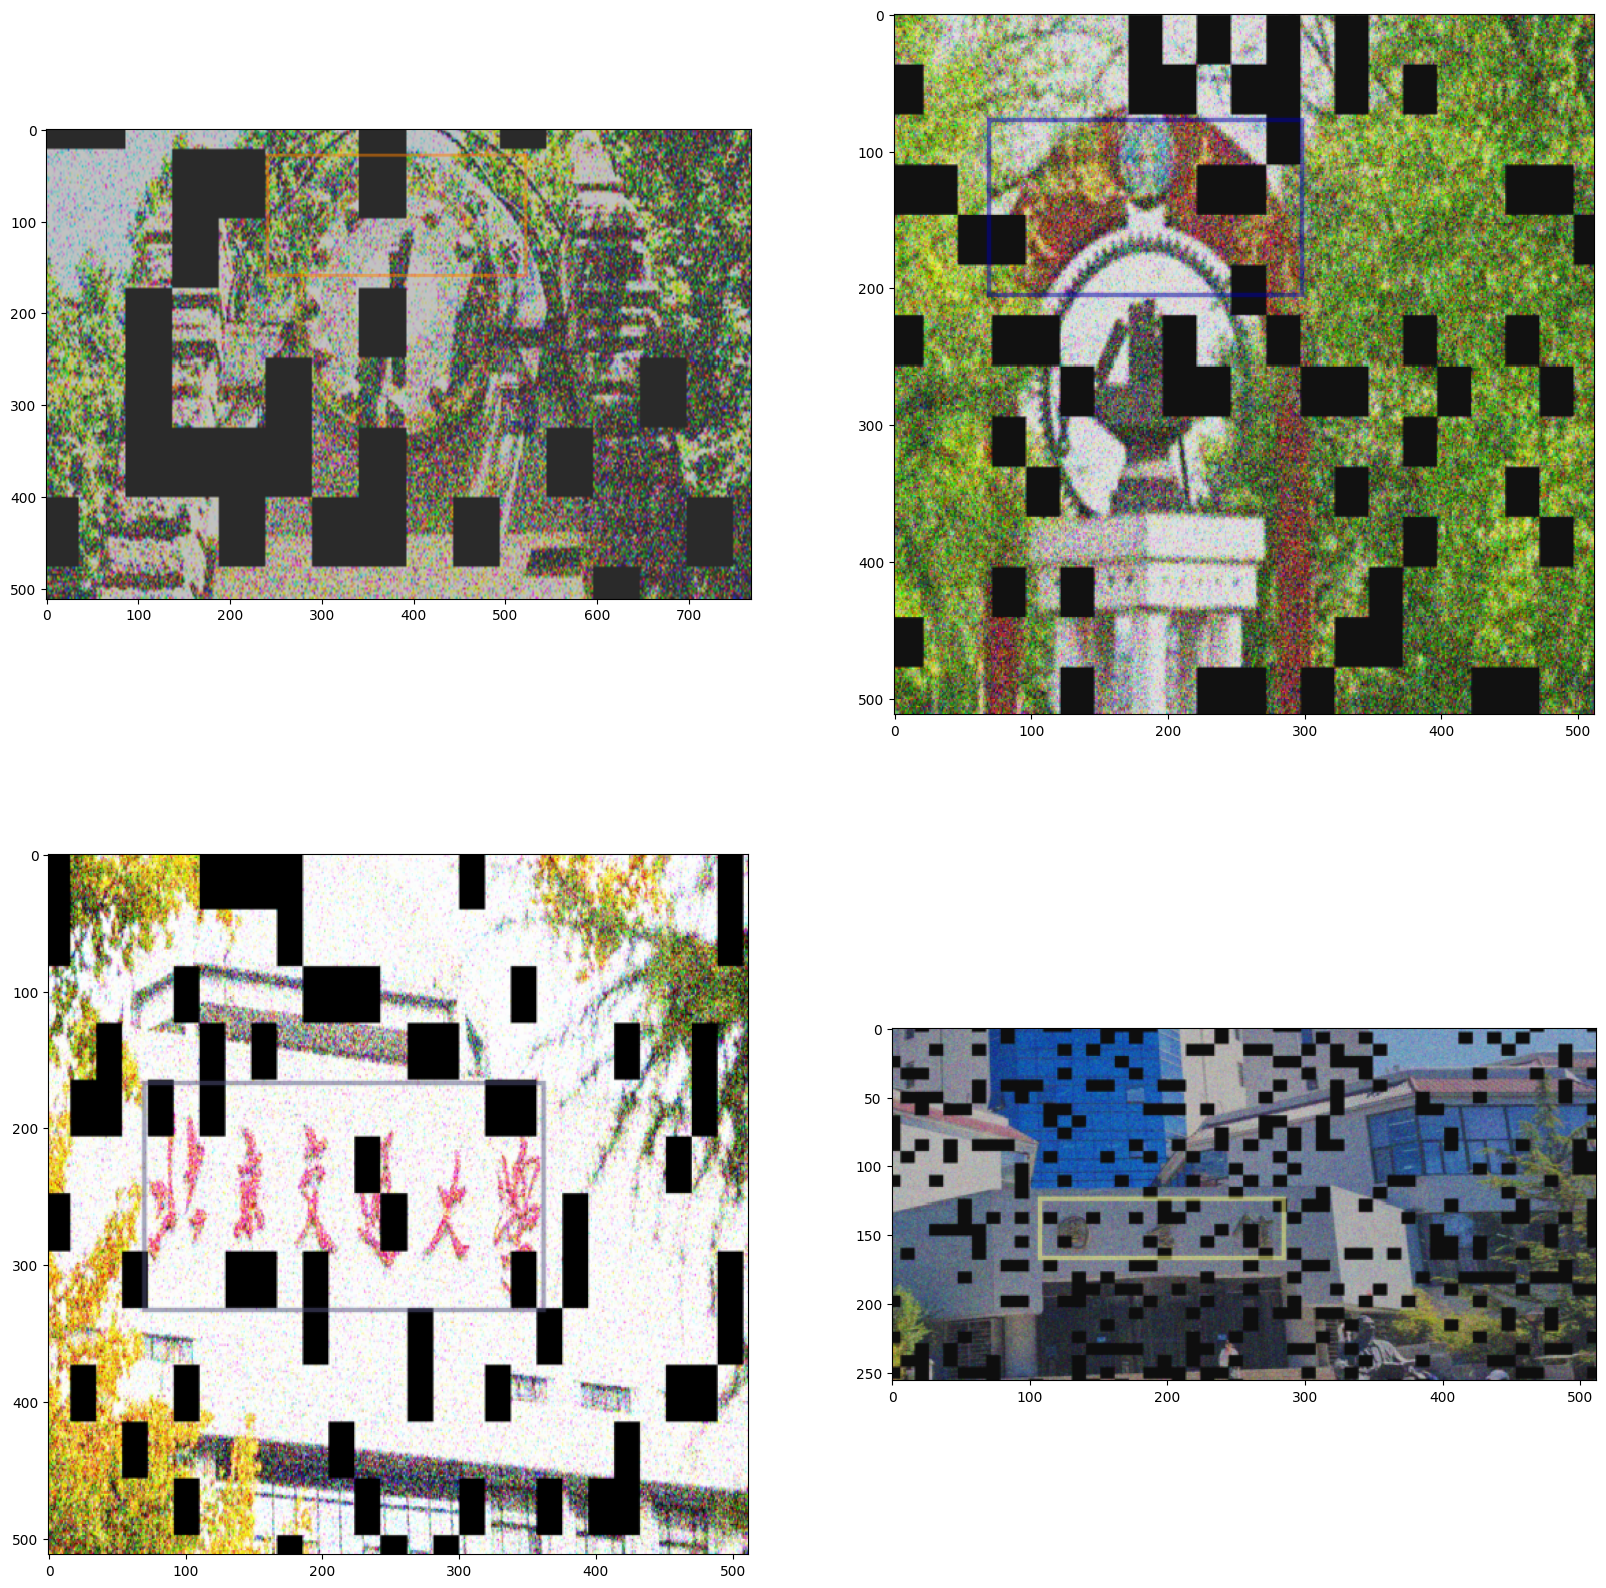

In [54]:

from detectron2.data import detection_utils as utils
def show_sample_from_trainer(cfg, trainer):
    train_data_loader = trainer.build_train_loader(cfg)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    data_iter = iter(train_data_loader)
    batch = next(data_iter)
    rows, cols = 2, 2
    plt.figure(figsize=(20,20))

    for i, per_image in enumerate(batch[:4]):
        
        plt.subplot(rows, cols, i+1)
        
        # Pytorch tensor is in (C, H, W) format
        img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = utils.convert_image_to_rgb(img, "BGR")

        visualizer = Visualizer(img, metadata=metadata, scale=1)

        target_fields = per_image["instances"].get_fields()
        labels = None
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
            keypoints=target_fields.get("gt_keypoints", None),
        )
        show_img = cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB) 
        
        plt.imshow(show_img)
show_sample_from_trainer(cfg, trainer)